# 7144COMP/CW2: Bird Multiple Object Detection Using Faster R-CNN ResNet101 Network 
## PART I: Data pre-processing and tagging
### Overview

In this part we will pre-process an image dataset (BBC AutumnWatch) in order to train an object detection model capable of classifying four distinct bird species.

- Using the image dataset provided (Birds.zip) I tagged 4 distinct bird classes with a minimum of 909 tags per class (see image statistics section)
- The species of birds chosen are: Pica_pica (923 tags), Periparus_ater	(978 tags), Turdus_merula (909 tags), Erithacus_Rubecula (999 tags)
- Using the generated tags and image data, I pre-processed xml files and generated a train/test/valid split of 80% train, 10% test and 10% for valid using Roboflow API. Each subset contains: Resized 640x640 images, an annotation/tagging csv file, a TFRecord file and a labelmap .pbtxt file


#### Prerequisites
This notebook runs locally on the environment *tf-gpu*.
- Environment Setup (see Part 0)
- **Kaggle CLI**: Original Data, Annotations, and Test, Train, Valid Records are downloaded from Kaggle using Kaggle CLI

#### Hardware Considerations
- The Notebook's Kernel must be set to **TensorFlowGPU** to use the computer's GPU
- Due to computational limitations, the max batch_size and num_epochs are set to 1

#### External tools:
- Roboflow: Dataset Test, Train, Valid Split, annotation csv, and TFRecord files creation.
- Code management and versioning: Git and GitHub

## 1. Import the necessary packages, Install OD API

In [58]:
import os
import pathlib

# Get the current working directory
current_dir = os.getcwd()
print('Root dir', current_dir)
# Clone the tensorflow models repository if it doesn't exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Root dir /home/msc1/Desktop/7144COMP/Models/faster_rcnn_resnet101


In [59]:
# Install Object Detection API
%cd $current_dir/models/research/
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!pip install .

In [60]:
# Return to the project root folder
%cd $current_dir

/home/msc1/Desktop/7144COMP/Models/faster_rcnn_resnet101


In [61]:
import os
import ast #<- evaluate string output and convert it to a data structure
import numpy as np
import pandas as pd

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import ops as utils_ops
from object_detection.utils import visualization_utils as vis_util

# Data visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Store plot outputs inside the notebook
%matplotlib inline

## 2. Setup, EDA

In [62]:
# Check the availability of GPU
physical_devices = tf.config.list_physical_devices()
print("Num GPUs Available: ", len(physical_devices))

# define constants
DATASET = 'Birds' # <- we are using version 3 hosted on Kaggle

print('TensorFlow version', tf.__version__)

Num GPUs Available:  1
TensorFlow version 2.11.0


### Image Labelling using labelImg

I used [labelImg](https://github.com/heartexlabs/labelImg), just another image tagging/annotation tool to create annotation XML files in **PASCAL VOC Format**.

<p><img src="https://ayoubb.com/wp-content/uploads/2022/12/Capture.png" width="600"/></p>
<br>




### Dataset Cleanup

Using the Roboflow API, I performed - before preprocessing - the following: 

- Dataset cleanup, validation, and versionning (jpg + xml files)
- Auto-orient, Auto-size suggestion: this is a part of preprocessing that is difficult to do on Jupyter Notebook
- TensorFlow Annotation CSV files, TFRecords and labelmap Generation
- Push the original + generated data to Kaggle (Roboflow API doesn't allow merging the original and processed data)

### Dataset Statistics


#### Download a copy of the latest version of our data from Kaggle
The file birdsannotated.zip contains:

- The original image dataset + XML annotation files
- Train/Test/Valid subsets containing each:
    - The preprocessed images (auto-oriented and resized)
    - An annotation CSV file 
    - A TFRecord file
    - a labelmap file (in .pbtxt format) 



In [63]:
# Download the latest version of our dataset containing both images and TFrecords
if not os.path.isdir(DATASET):
    !kaggle datasets download -d ayoubbensakhria/birdsannotated --unzip

In [64]:
# Download script for Image Dimension stats, class balance and annotations 
# Remove current file
!rm getDimensions.py
# get the latest version of getDimensions.py from GitHub
!wget https://raw.githubusercontent.com/ayoubbensakhria/TensorFlowOD/master/7144COMP/preprocessing/getDimensions.py

--2022-12-21 21:48:52--  https://raw.githubusercontent.com/ayoubbensakhria/TensorFlowOD/master/7144COMP/preprocessing/getDimensions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2559 (2.5K) [text/plain]
Saving to: ‘getDimensions.py’

getDimensions.py    100%[===================>]   2.50K  --.-KB/s    in 0s      

2022-12-21 21:48:53 (89.4 MB/s) - ‘getDimensions.py’ saved [2559/2559]



### Visualise image dimensions

In [29]:
# get raw output from getDimensions.py
# hwp_output[0] = hw_pairs, hwp_output[1] = annotations 
hwp_output = !python getDimensions.py -i $current_dir/$DATASET

In [30]:
# Parse output and convert to a list of coordinate tuples
hw_pairs = ast.literal_eval(hwp_output[0])
# convert to df
df_hwpairs = pd.DataFrame(hw_pairs, columns = ['width','height'])
df_hwpairs.describe().round(2)

width   height
count  4000.00  4000.00
mean    803.42   927.22
std     162.86   155.77
min     142.00   140.00
25%     683.00   768.00
50%     768.00  1024.00
75%    1024.00  1024.00
max    1024.00  1024.00

- Since the means of the heights and the widths are less than 1024px, downsizing our images instead of increasing the size of small images to be larger might be a better option (Source: [Roboflow](https://blog.roboflow.com/you-might-be-resizing-your-images-incorrectly/))

- The suggested size was 640x640 by Roboflow taking into consideration our model input resolution (640x640px) and the size of the quartile of our image dimension dataset. 

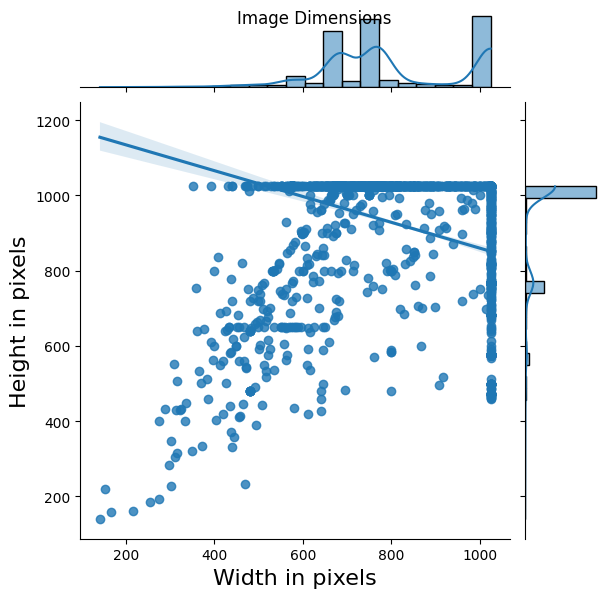

In [32]:
# Visualise width vs height in a Joint Plot
plot = sns.jointplot(data=df_hwpairs, x='width', y='height', kind='reg')
plot.set_axis_labels('Width in pixels', 'Height in pixels', fontsize=16)
plot.fig.suptitle("Image Dimensions")
plot

### Class Balance / Annotations Count



In [34]:
# Annotation output is the second element of the array hwp_output
annotations = ast.literal_eval(hwp_output[1])
# convert to df
df_annotations = pd.DataFrame.from_dict(annotations, orient='index', columns=['Count'])
df_annotations

Count
Pica_pica             923
Periparus_ater        978
Turdus_merula         909
Erithacus_Rubecula    999

Text(0.5, 0, 'Annotation XML files count')

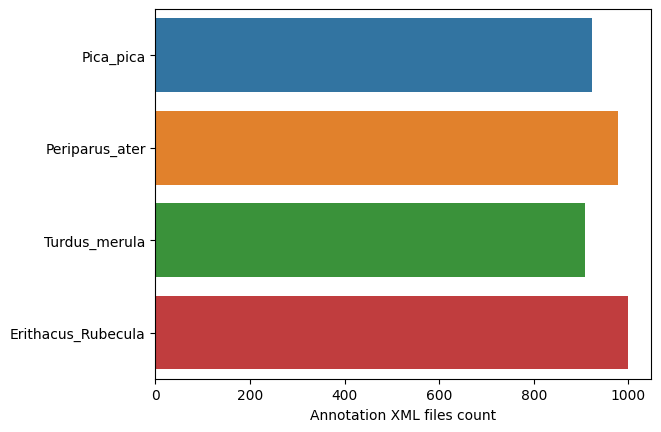

In [35]:
# Plot annotation counts
ax = sns.barplot(x='Count', y=df_annotations.index, data=df_annotations)
ax.set_xlabel('Annotation XML files count')

### Annotation Heatmap
- The goal of annotation heatmap is to visualise the the location centres of our target objects (Birds) on the train dataset.

- Annotation coordinates are stored in a csv file in train/test/valid folders. Here we are interested in the train dataset.


In [44]:
# Load annotation CSV from the train Subset
df_annotations = pd.read_csv(os.path.join(current_dir, DATASET, 'train/_annotations.csv'))
# Compute the average of x, y coordinates 
# Witch represents the center of rectangle or the midpoint of the diagonal end points of rectangle
df_annotations['average_x'] = (df_annotations['xmin'] + df_annotations['xmax'])/2
df_annotations['average_y'] = (df_annotations['ymin'] + df_annotations['ymax'])/2
df_annotations.head()

filename  width  height  \
0  Turdus_merula-_-704-_jpg.rf.f999df7f292b163efa...    640     640   
1  ErithacusRubecula0003_jpg.rf.f9c5a4232534ca9db...    640     640   
2  Turdus_merula-_-285-_jpg.rf.f9ecded13dae7d0e70...    640     640   
3  Periparus_ater-_-372-_jpg.rf.fa0eedf8939bd80d2...    640     640   
4  Periparus_ater-_-372-_jpg.rf.fa0eedf8939bd80d2...    640     640   

                class  xmin  ymin  xmax  ymax  average_x  average_y  
0       Turdus_merula   256   166   383   395      319.5      280.5  
1  Erithacus_Rubecula   290   272   461   493      375.5      382.5  
2       Turdus_merula   285   168   334   198      309.5      183.0  
3      Periparus_ater    98   190   190   274      144.0      232.0  
4      Periparus_ater   511   231   545   273      528.0      252.0

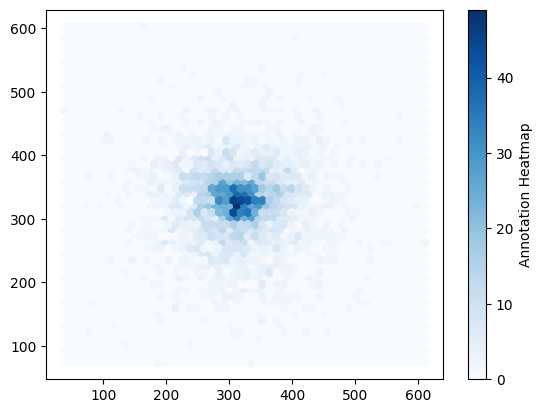

In [57]:
# Plot annotation coordinates in the scaled images (640x640 px)
plt.hexbin(df_annotations['average_x'], df_annotations['average_y'],
           bins=50, cmap='Blues', gridsize=50)
cb = plt.colorbar(label='Annotation Heatmap')

- We can see that most birds are located approximately 300-400 pixels to the left and top of each image. 
- This location bias can be a problem when locating objects (birds) that are far from the centre of each image.

## 3. Pre-processing



### Auto-Orient

EXIF data is useful information about a JPEG image, hidden inside the file. When images are photographed, digital cameras use orientation sensors to store an EXIF orientation value for how the camera is held.

- Auto-Orient discards EXIF rotations and standardizes pixel ordering.

### Resizing 
- Training images are downsized  for smaller file sizes and faster training (640x640 px). **(Justification: Refer to EDA Section)**
- Annotations are scaled proportionally.

### Image augmentation
Image augmentation can increase the generalizability of the model's performance by increasing the diversity of learning examples and consequently reducing the risk of overfitting.

Images augmentations performed during the training process are included in the **fasterrcnn_config.config** file: 
- random_horizontal_flip 
- random_adjust_hue 
- random_adjust_contrast 
- random_adjust_saturation 
- random_square_crop_by_scale 

### (Alternative Option) Bounding-Box-Level Augmentation Using Roboflow

Bounding box augmentation updates the coordinates of the bounding boxes automatically when the content of an image is altered.


### Test, Train, Valid split

Test, Train, Valid subsets were created using Roboflow. 

Each subset contains: 
- Resized images (640x640px) (80% out of the total for train, 10% for test and 10% for valid)
- An annotation csv file
- A TFRecord file
- labelmap .pbtxt format file

<p><img src="https://ayoubb.com/wp-content/uploads/2022/12/Roboflow-Annotation-Capture.png" width="600"/></p>



## Next Steps

Next, we will train an object detection model using the pre-processed data. 
The following illustrates the process from data ingestion to inference.
<img src="https://ayoubb.com/wp-content/uploads/2022/12/Flowchart-3.jpg" />